# importings

In [1]:
import nltk
from nltk.corpus import stopwords

import re
from time import time

nltk.download('stopwords')
sno = nltk.stem.SnowballStemmer('english')
stop = set(stopwords.words('english'))


import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dblpcitationnetwork-v13/data/dblpv13_wo_numberint.csv


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Basic Preparation and Cleaning data

In [2]:
# df[(df['n_citation'] > 1)].plot.hist(bins=50)

# df[(df['n_citation'] < 100)
#    & (df['n_citation'] > 1)
#   ].plot.hist(bins=50)

# df[(df['n_citation'] < 100) & (df['n_citation'] > 1)].plot.hist(bins=50)

In [3]:
df = pd.read_csv('../input/dblpcitationnetwork-v13/data/dblpv13_wo_numberint.csv', 
                 usecols=['_id','title','keywords', 'abstract', 'n_citation', 'lang'])

df.head()

,_id,title,keywords,n_citation,lang,abstract
0,53e99784b7602d9701f3e3f5,3GIO.,[],0.0,en,NaN
1,53e99784b7602d9701f3e133,The relationship between canopy parameters and...,"['canopy parameters', 'canopy spectrum', 'diff...",0.0,en,Drought is the first place in all the natural ...
2,53e99784b7602d9701f3e151,A solution to the problem of touching and brok...,"['handwriting recognition', 'prototypes', 'ima...",17.0,en,NaN
3,53e99784b7602d9701f3e15d,Timing yield estimation using statistical stat...,"['sequential circuits', 'statistical distribut...",28.0,en,As process variations become a significant pro...
4,53e99784b7602d9701f3e161,360°,"['global high technology', 'daily short-distan...",NaN,en,360° represents the concerns that are addresse...


In [4]:
def get_cleaned_sents(series):
    def cleanpunc(sentence):
        cleaned = re.sub(r'[?|!|\'|"|#]',r'', sentence)
        cleaned = re.sub(r'[.|,|)|(|\|/-]',r' ', cleaned)
        return  cleaned

    final_string = []
    for sent in series.values:
        sent = str(sent)
        filtered_sentence=[]
        for word in sent.split():
            for cleaned_words in cleanpunc(word).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words) > 2)):    
                    if(cleaned_words.lower() not in stop):
                        s = (sno.stem(cleaned_words.lower())).encode('utf-8')
                        filtered_sentence.append(s)
        final_string.append(b' '.join(filtered_sentence))
    
    return pd.Series(final_string).str.decode('utf-8').values

In [5]:
df_clean = df[
    (df['keywords'].isnull() == False) & 
    (df['keywords'] != '[]') & 
    (df['n_citation'].isna() == False) & 
    (df['n_citation'] >= 25) & 
    (df['title'].apply(lambda x: len(str(x).split())) >= 3) & 
    (df['title'].apply(lambda x: len(str(x).split())) <= 50) &
    (df['lang'] == 'en')
]

df_clean = df_clean.dropna()
df_clean = df_clean.drop(columns=['lang'])
df_clean.drop(df_clean[df_clean['abstract'].map(lambda x: ' der ' in str(x))].index, inplace=True)
df_clean.drop(df_clean[df_clean['title'].map(lambda x: ' der ' in str(x))].index, inplace=True)

print('% of returned df_clean: ', df_clean.shape[0] / df.shape[0] * 100)
print('shape of df_clean: ', df_clean.shape[0])

cleanup_kw = lambda x: ' '.join(re.findall("\w+", x)).lower()
df_clean['clean_kw'] = df_clean['keywords'].apply(cleanup_kw)


% of returned df_clean:  11.88073008113652
shape of df_clean:  636131


In [6]:
t0 = time()
print('Start cleaning data')

df_clean = df_clean.drop(columns=['abstract'])
# df_clean['clean_abstract'] = get_cleaned_sents(df_clean['abstract'])

df_clean['clean_title'] = get_cleaned_sents(df_clean['title'])
df_clean['clean_kw'] = get_cleaned_sents(df_clean['clean_kw'])

print('End of cleaning data, time: %s' % (time() - t0))

Start cleaning data
End of cleaning data, time: 448.5740444660187


In [7]:
df_clean.head()

,_id,title,keywords,n_citation,clean_kw,clean_title
3,53e99784b7602d9701f3e15d,Timing yield estimation using statistical stat...,"['sequential circuits', 'statistical distribut...",28.0,sequenti circuit statist distribut set time co...,time yield estim use statist static time analysi
23,53e99784b7602d9701f3f411,Using XML to Integrate Existing Software Syste...,"['Internet', 'hypermedia markup languages', 'i...",28.0,internet hypermedia markup languag inform reso...,use xml integr exist softwar system web
4314,53e99792b7602d9701f5af35,An approach to feature location in distributed...,"['Feature location', 'Distributed systems', 'S...",62.0,featur locat distribut system softwar reconnaiss,approach featur locat distribut system
4377,53e99792b7602d9701f5b10e,WAVELET-BASED IMAGE COMPRESSION ANTI-FORENSICS,"['mathematical model', 'digital images', 'wave...",45.0,mathemat model digit imag wavelet transform di...,wavelet base imag compress anti forens
4379,53e99792b7602d9701f5b119,A fuzzy multi-objective programming for optimi...,"['Location', 'Fire stations', 'Multi-objective...",140.0,locat fire station multi object program genet ...,fuzzi multi object program optim fire station ...


In [8]:
df_clean.to_csv('df_clean.csv')

# topic modeling with NMF and LDA methods

In [9]:
from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

# n_features = 1000
n_components = 10 # n_topics
n_top_words = 10
init = "nndsvda"

data_samples = df_clean['clean_kw']

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

Extracting tf features for LDA...
done in 475.302s.



Fitting LDA models with tf features
done in 1855.759s.


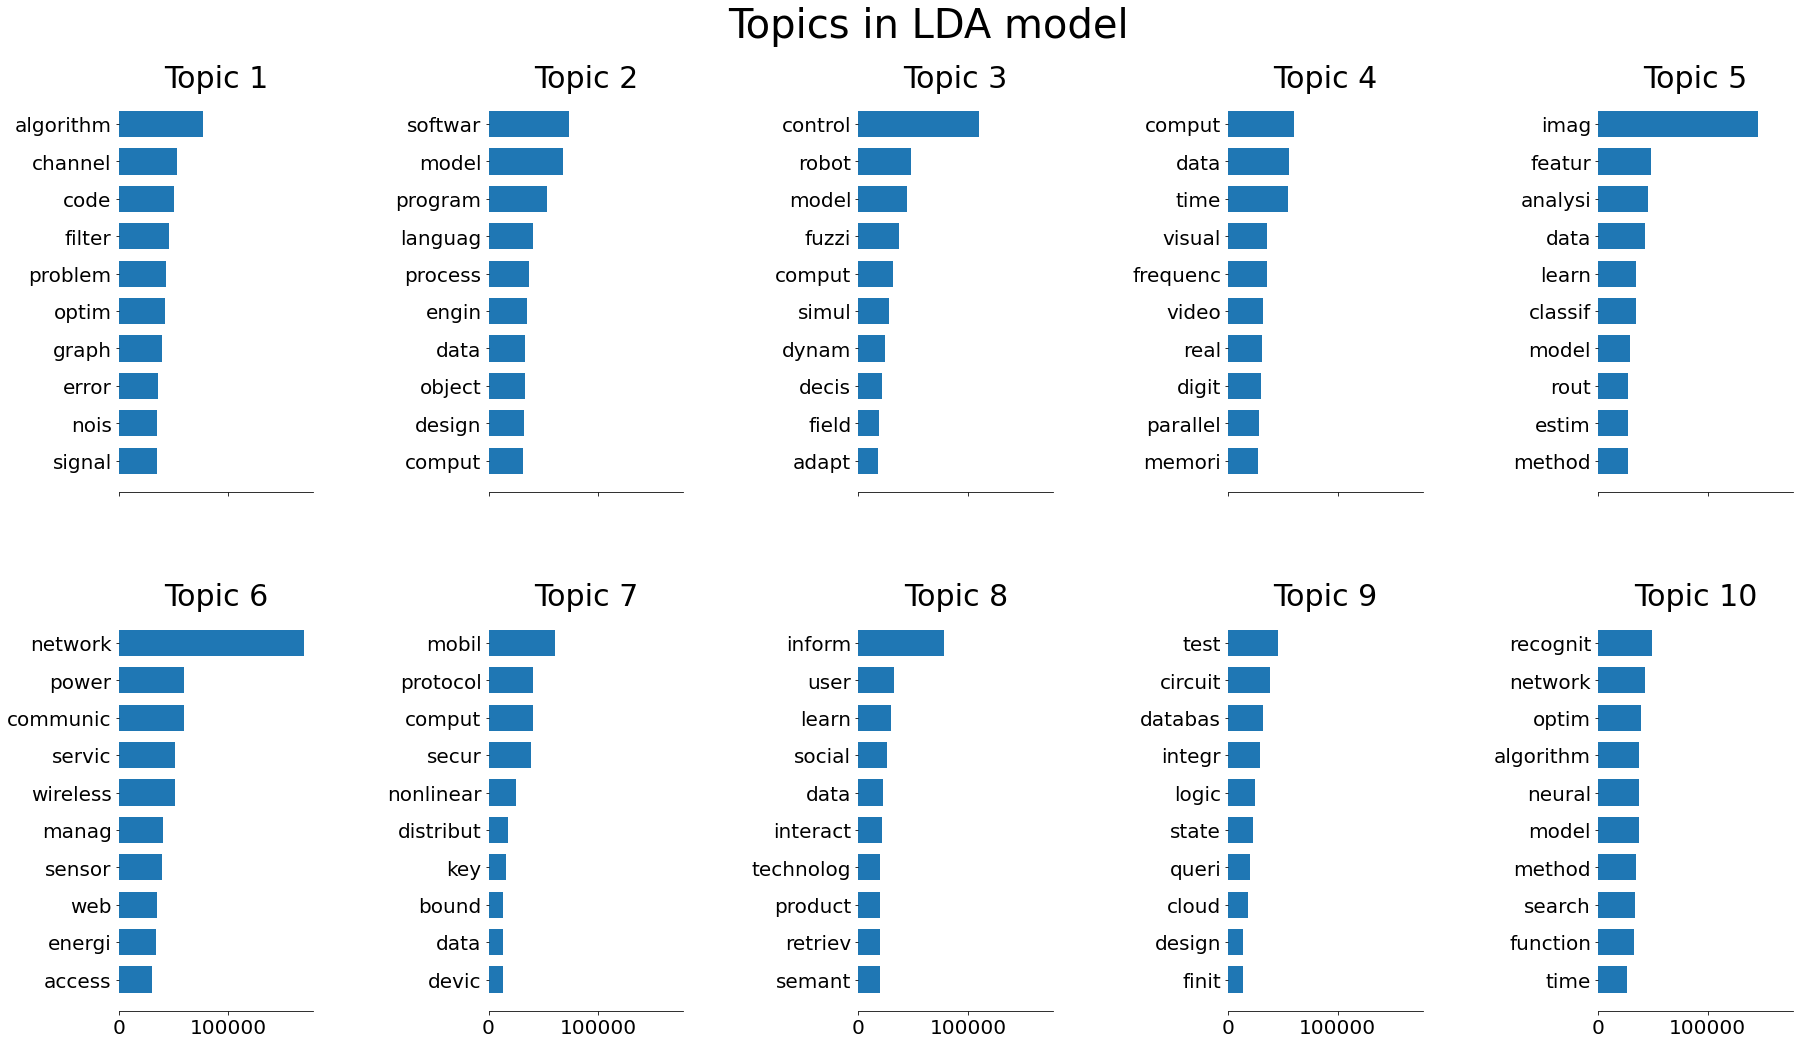

In [10]:
# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words="english")
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()


print("\n\nFitting LDA models with tf features")
lda = LatentDirichletAllocation(n_components=n_components, learning_method="online")
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")


In [11]:
# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=5, stop_words="english")
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

Extracting tf-idf features for NMF...
done in 17.341s.


Fitting the NMF model (Frobenius norm) with tf-idf features
done in 99.102s.


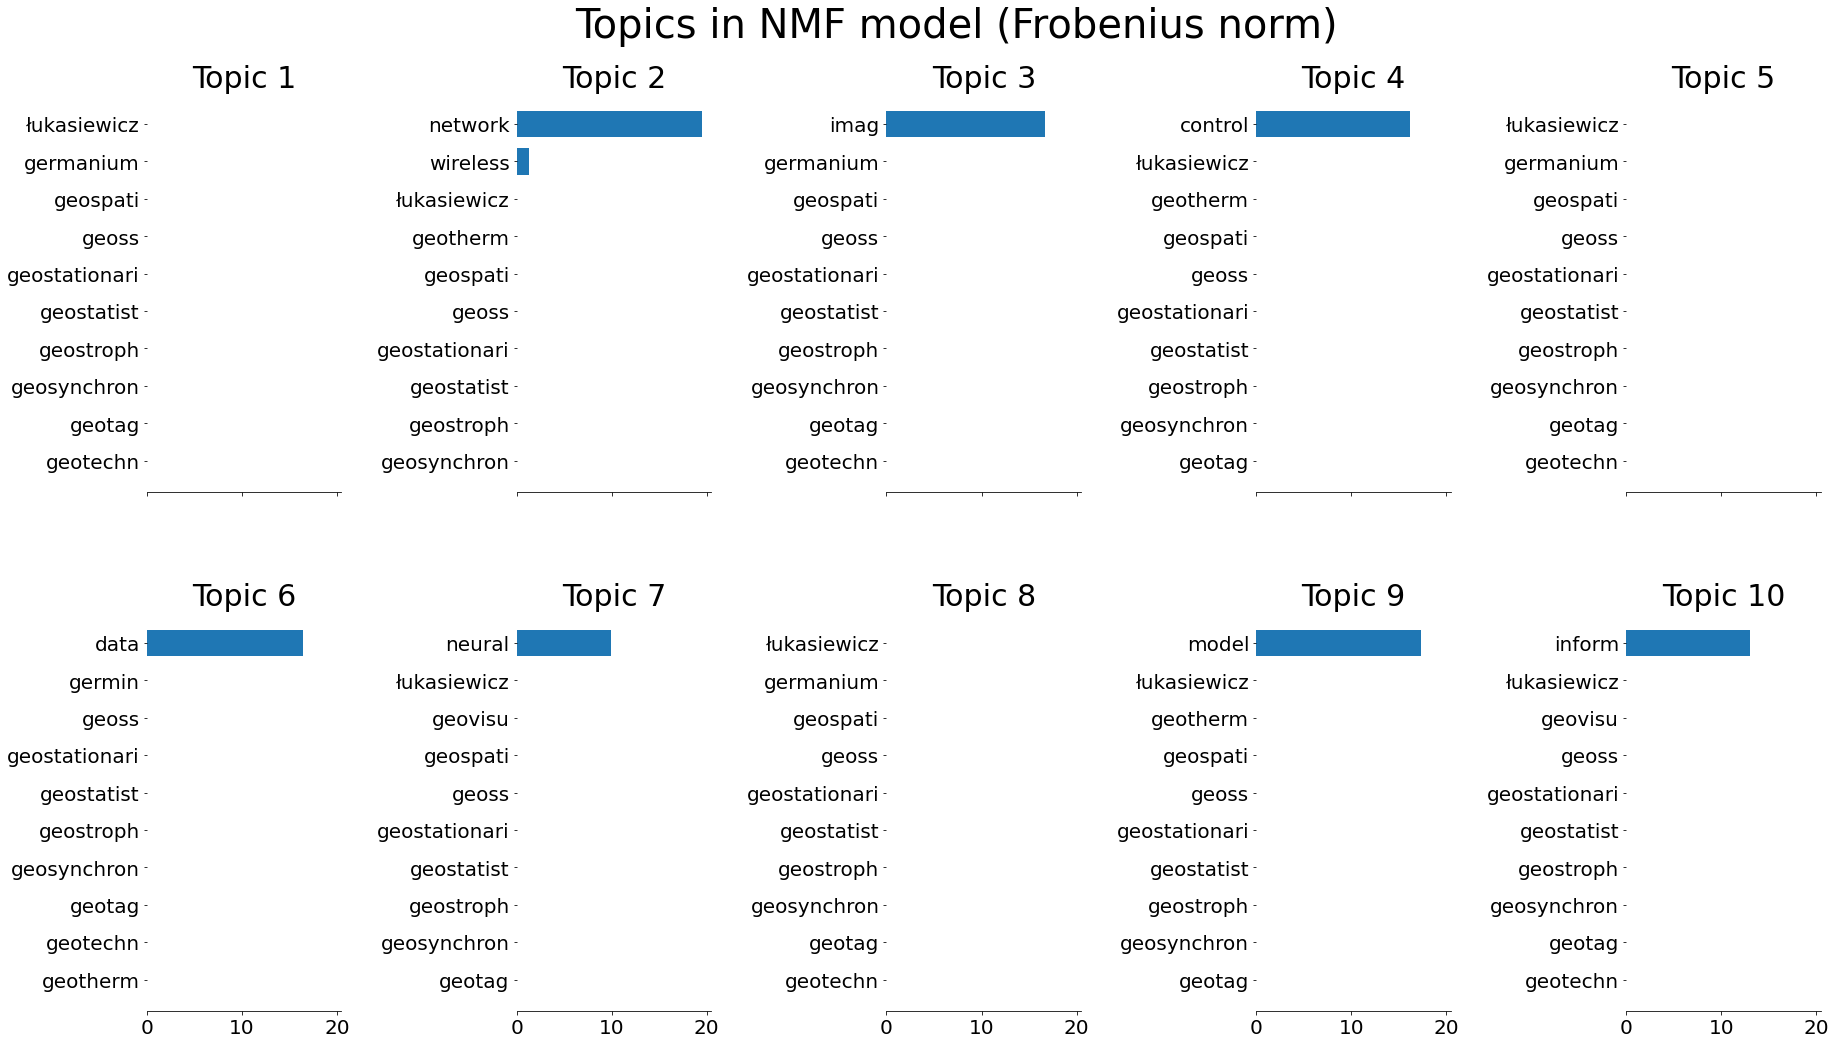

In [12]:
# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features")
t0 = time()
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)")




Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features
done in 726.452s.


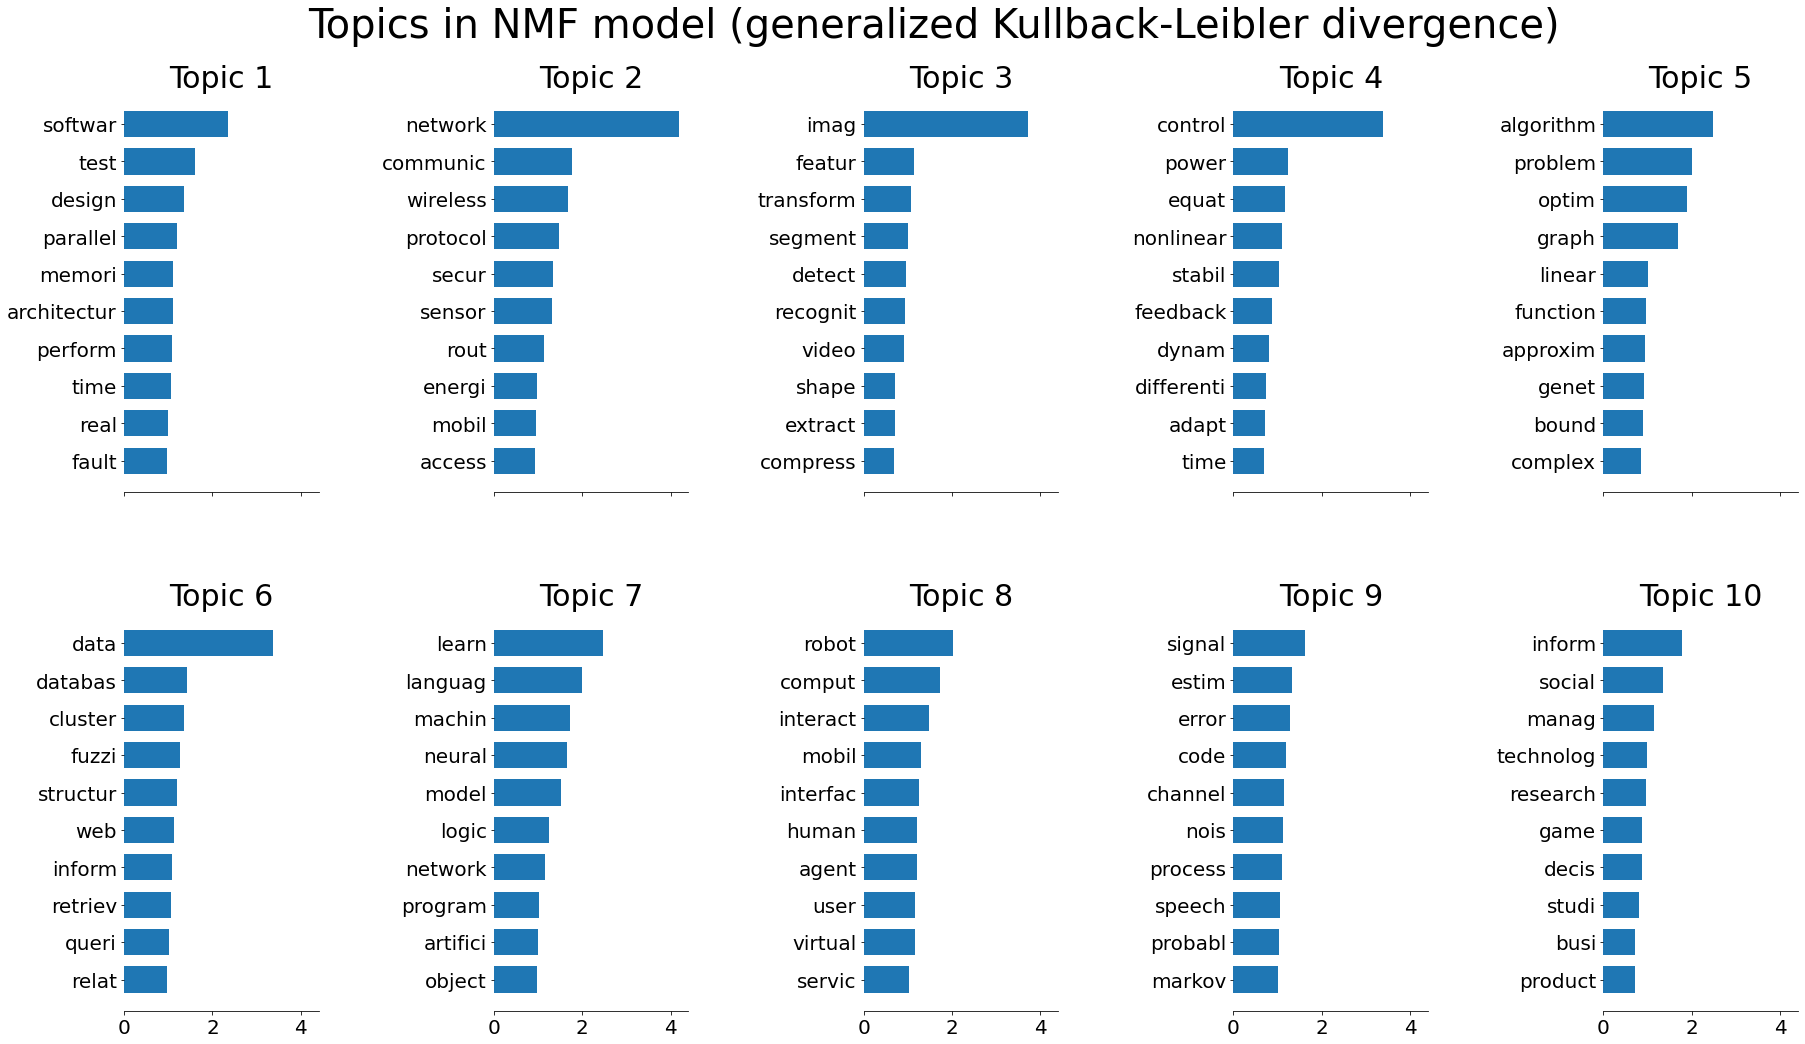

In [13]:

print("\n\nFitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features")
t0 = time()
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)

print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)

# topic modeling LDA (another one)

In [14]:
df_clean_small = df_clean[df_clean['n_citation'] >= 400]

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.sklearn

/opt/conda/lib/python3.7/site-packages/past/types/oldstr.py:36: DeprecationWarning: invalid escape sequence \d
  """
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [16]:
cv = CountVectorizer(max_df=0.95, min_df=15, stop_words='english')
dtm = cv.fit_transform(df_clean_small['clean_kw'])
dtm

<24820x2526 sparse matrix of type '<class 'numpy.int64'>'
	with 411642 stored elements in Compressed Sparse Row format>

In [17]:
NB_TOPICS = 25
LDA_model = LatentDirichletAllocation(n_components = NB_TOPICS, random_state = 69)
LDA_model.fit(dtm)

LatentDirichletAllocation(n_components=25, random_state=69)

In [18]:
for i, topic in enumerate(LDA_model.components_):
    print("THE TOP {} WORDS FOR TOPIC #{}".format(10, i))
    print([cv.get_feature_names()[index] for index in topic.argsort()[-10:]])
    print("\n")

THE TOP 10 WORDS FOR TOPIC #0
['maximum', 'distribut', 'filter', 'speech', 'probabl', 'statist', 'markov', 'estim', 'process', 'model']


THE TOP 10 WORDS FOR TOPIC #1
['equat', 'spars', 'problem', 'point', 'approxim', 'algorithm', 'optim', 'matrix', 'linear', 'method']


THE TOP 10 WORDS FOR TOPIC #2
['term', 'index', 'error', 'wavelet', 'net', 'transform', 'compress', 'network', 'neural', 'code']


THE TOP 10 WORDS FOR TOPIC #3
['scienc', 'chain', 'environ', 'organ', 'physic', 'simul', 'self', 'product', 'comput', 'virtual']


THE TOP 10 WORDS FOR TOPIC #4
['recommend', 'structur', 'servic', 'user', 'search', 'inform', 'queri', 'databas', 'web', 'data']


THE TOP 10 WORDS FOR TOPIC #5
['filter', 'textur', 'analysi', 'process', 'detect', 'face', 'pattern', 'recognit', 'segment', 'imag']


THE TOP 10 WORDS FOR TOPIC #6
['model', 'technolog', 'human', 'inform', 'comput', 'fuzzi', 'research', 'interact', 'user', 'social']


THE TOP 10 WORDS FOR TOPIC #7
['comput', 'radio', 'hoc', 'rout',

In [19]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(LDA_model, dtm, cv, mds='tsne') 
panel

PreparedData(topic_coordinates=               x          y  topics  cluster      Freq
topic                                                 
7     -31.058315  29.500683       1        1  7.438303
14    -21.461353 -17.436399       2        1  6.179840
6      -6.096575 -39.141697       3        1  5.599208
18     56.071609  -9.400822       4        1  5.271083
4      61.351185 -56.833744       5        1  5.086457
1      17.821402  57.413609       6        1  4.890105
13     49.250862  50.355305       7        1  4.850062
0     -13.172927  53.618752       8        1  4.547553
11     31.702734 -64.520691       9        1  4.461640
19     14.361623   7.507676      10        1  4.291297
21     29.184048 -13.613249      11        1  4.255184
5      19.284979 -39.023891      12        1  4.134901
16      4.356016 -15.153996      13        1  3.926518
20    -12.708655   6.676149      14        1  3.864571
8     -46.884609 -28.260098      15        1  3.515153
10    -28.764826 -54.799591      16        1  3.473078
2      62.600399  25.238491      17        1  2.950202
17    -43.313934   3.224185      18        1  2.885268
12     44.929001 -34.219784      19        1  2.868737
22     81.611572   3.921941      20        1  2.846385
3       0.798218  29.447706      21        1  2.734184
9       2.051419 -67.215591      22        1  2.699353
24     27.693497  31.413803      23        1  2.560669
15     40.470249   9.942824      24        1  2.445110
23     76.766655 -28.811687      25        1  2.225138, topic_info=         Term          Freq         Total Category  logprob  loglift
1515  network  10530.000000  10530.000000  Default  30.0000  30.0000
1079     imag   7001.000000   7001.000000  Default  29.0000  29.0000
481   control   3966.000000   3966.000000  Default  28.0000  28.0000
2323     time   3934.000000   3934.000000  Default  27.0000  27.0000
1431    model   8265.000000   8265.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
426    comput    137.926457   8733.722356  Topic25  -4.6045  -0.3429
742     engin    101.179949   1548.767033  Topic25  -4.9143   1.0770
1056    human     93.190741   1345.250264  Topic25  -4.9965   1.1357
79    analysi    101.260455   5237.816373  Topic25  -4.9135  -0.1406
1368   mechan     82.459768    640.275700  Topic25  -5.1189   1.7558

[1500 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1         2  0.034220  abnorm
1        12  0.034220  abnorm
1        19  0.136879  abnorm
1        24  0.752833  abnorm
8         3  0.958089  accept
...     ...       ...     ...
2515      7  0.041171   worst
2515     13  0.936635   worst
2518      1  0.935147     wsn
2519      5  0.977090     www
2520      5  0.996773     xml

[6118 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 15, 7, 19, 5, 2, 14, 1, 12, 20, 22, 6, 17, 21, 9, 11, 3, 18, 13, 23, 4, 10, 25, 16, 24])

# Embeddings (visualize)

In [20]:
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=5523405b2e9fd2c5bf5b2604593b6ffa15a77e0955251875591fd9b9a6769090
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [21]:
from sentence_transformers import SentenceTransformer
sentences = df_clean_small.title.to_list()

embeding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = embeding_model.encode(sentences)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Batches:   0%|          | 0/776 [00:00<?, ?it/s]

In [22]:
from umap import UMAP
import umap.plot

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


<AxesSubplot:>

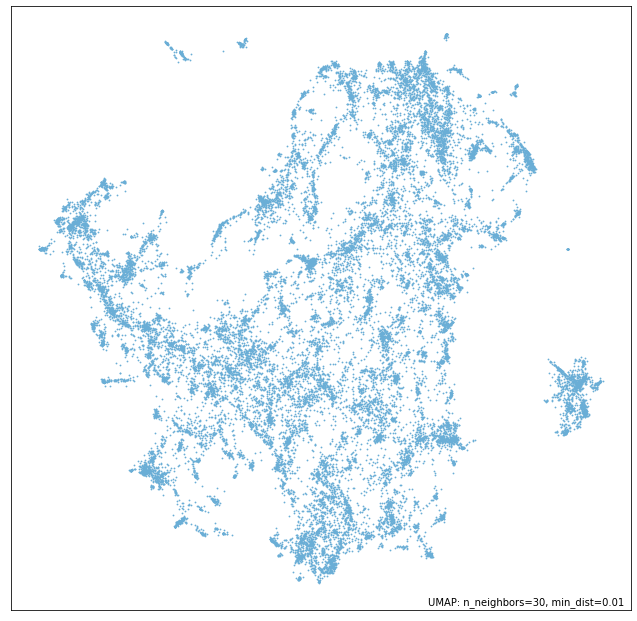

In [23]:
mapper = UMAP(n_components=2, n_neighbors=30, min_dist=0.01).fit(embeddings)
umap.plot.points(mapper)

# Topic modeling (bert)

In [24]:
!pip install bertopic

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.6/636.6 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 54.3 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done

/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


 / - \ | / - done
  Created wheel for hdbscan: filename=hdbscan-0.8.29-cp37-cp37m-linux_x86_64.whl size=3426396 sha256=14ed9f9ecc3bb518647616c6cf0d0b3204d5e71ee3b0484885868a4c9334b7de
  Stored in directory: /root/.cache/pip/wheels/93/78/2e/03ee191669a772e9653260aa3bd53e0b1a768751a9676e8c82
Successfully built hdbscan
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.1.0 requires markupsafe~=2.0.1, but you have markupsafe 2.1.1 which is incompatible.
allennlp 2.10.0 requires protobuf==3.20.0, but you have protobuf 3.19.4 which is incompatible.


In [25]:
from bertopic import BERTopic

/opt/conda/lib/python3.7/site-packages/transformers/image_utils.py:222: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  def resize(self, image, size, resample=PIL.Image.BILINEAR, default_to_square=True, max_size=None):


In [26]:
lst = np.random.random_integers(0, 636130, size=50000)
df_clean = df_clean.reset_index(drop=True)
df_clean_bert = df_clean.iloc[lst, :]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: This function is deprecated. Please call randint(0, 636130 + 1) instead
  """Entry point for launching an IPython kernel.


In [27]:
print('df_clean.shape', df_clean.shape)
print('df_clean_bert.shape', df_clean_bert.shape)

df_clean.shape (636131, 6)
df_clean_bert.shape (50000, 6)


In [28]:
model_clean_kw = BERTopic(verbose=True, embedding_model='all-MiniLM-L6-v2', nr_topics=29)
headline_topics, _ = model_clean_kw.fit_transform(df_clean_bert['clean_kw'].values)

freq_clean_kw = model_clean_kw.get_topic_info()
print("Number of topics: {}".format(len(freq_clean_kw)))
freq_clean_kw.head(50)

Batches:   0%|          | 0/1563 [00:00<?, ?it/s]

2022-11-18 23:27:39,851 - BERTopic - Transformed documents to Embeddings
2022-11-18 23:28:25,936 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2022-11-18 23:28:31,049 - BERTopic - Clustered reduced embeddings
2022-11-18 23:28:53,042 - BERTopic - Reduced number of topics from 483 to 30


Number of topics: 30


,Topic,Count,Name
0,-1,32145,-1_system_comput_model_data
1,0,1510,0_channel_radio_interfer_optic
2,1,930,1_speech_recognit_music_acoust
3,2,883,2_sensor_wireless_network_hoc
4,3,825,3_control_stabil_system_nonlinear
5,4,796,4_gene_microarray_biolog_bioinformat
6,5,792,5_robot_gait_kinemat_control
7,6,763,6_video_compress_motion_code
8,7,691,7_wavelet_filter_transform_signal
9,8,679,8_inform_busi_technolog_system


In [29]:
model_clean_kw.visualize_topics(top_n_topics=25)

In [30]:
model_clean_kw.visualize_hierarchy(top_n_topics=25, width=800)

/opt/conda/lib/python3.7/site-packages/plotly/figure_factory/_dendrogram.py:350: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

/opt/conda/lib/python3.7/site-packages/plotly/figure_factory/_dendrogram.py:351: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

/opt/conda/lib/python3.7/site-packages/plotly/figure_factory/_dendrogram.py:352: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

/opt/conda/lib/python3.7/site-packages/plotly/figure_factory/_dendrogram.py:353: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead



# Embeddings (another one)

In [31]:
lst = np.random.random_integers(0, 636130, size=150_000)
df_clean = df_clean.reset_index(drop=True)
df_clean_bert = df_clean.iloc[lst, :]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

This function is deprecated. Please call randint(0, 636130 + 1) instead



In [32]:
print('df_clean.shape', df_clean.shape)
print('df_clean_bert.shape', df_clean_bert.shape)

df_clean.shape (636131, 6)
df_clean_bert.shape (150000, 6)


## Get Enbeddings

In [33]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(df_clean_bert['title'].values, show_progress_bar=True)

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/450 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Batches:   0%|          | 0/4688 [00:00<?, ?it/s]

## generate low dim

In [34]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=15,
                            n_components=20, 
                            metric='cosine').fit_transform(embeddings)

## clustering

In [35]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

In [36]:
# import hdbscan
# cluster = hdbscan.HDBSCAN(min_cluster_size=15,
#                           metric='cosine',                      
#                           cluster_selection_method='eom').fit(umap_embeddings)

In [37]:
cluster = KMeans(n_clusters=50).fit(umap_embeddings)

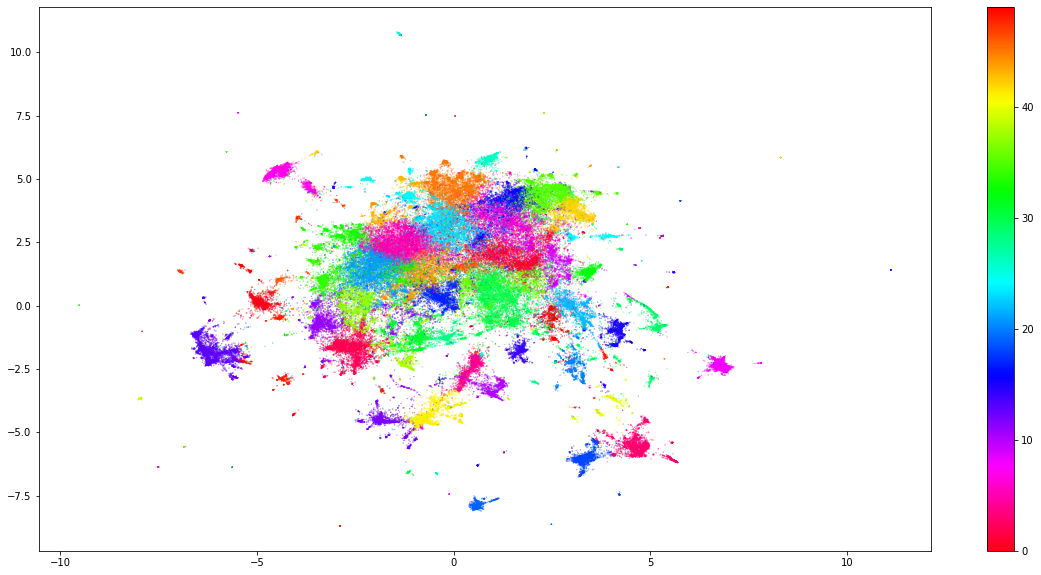

In [38]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

## topic cleation

In [39]:
docs_df = pd.DataFrame(df_clean_bert['title'].values, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [40]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(df_clean_bert))

In [41]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
30,30,7780
5,5,7425
21,21,6238
2,2,5744
23,23,5657
45,45,5329
13,13,5137
1,1,4814
35,35,4760
3,3,4396


In [42]:
for i in range(20):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(df_clean_bert)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df); 
topic_sizes.head(10)

,Topic,Size
13,12,10113
18,17,9742
3,2,9137
17,16,8402
15,14,8046
0,-1,6693
20,19,6451
1,0,5744
27,26,5565
28,27,5329


In [43]:
topic_sizes.shape

(30, 2)

In [44]:
def extract_top_n_words_per_topic_mine(tf_idf, count, docs_per_topic, n=4):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: ' '.join([(words[j]) for j in indices[i]][::-1]) for i, label in enumerate(labels)}
    return top_n_words


In [45]:
mapping_real = extract_top_n_words_per_topic_mine(tf_idf, count, docs_per_topic, n=4)

In [46]:
mapping_real

{-1: 'fast efficient algorithm optimal',
 0: 'web online social internet',
 1: 'wireless networks sensor radio',
 2: 'logic based xml data',
 3: 'nonlinear systems discrete time',
 4: 'graphs graph trees tree',
 5: 'mimo channels noise optical',
 6: 'learning virtual computer science',
 7: 'genetic protein gene algorithm',
 8: 'complexity fault problem systems',
 9: 'memory java real time',
 10: 'mobile networks ad hoc',
 11: 'dimensional way second phase',
 12: 'information systems medical based',
 13: 'power energy control cmos',
 14: 'optimization based using particle',
 15: 'fuzzy markov statistical neural',
 16: 'robot robots control using',
 17: 'image video 3d based',
 18: 'security privacy attacks based',
 19: 'learning speech recognition language',
 20: 'software mining engineering database',
 21: 'blind non lower unsupervised',
 22: 'high large efficient sensor',
 23: 'business supply process information',
 24: 'neural brain using networks',
 25: 'low sparse power free',
 26:

In [47]:
mapping_class = {-1:'Computer Science - General',
                 0: 'Machine Leaning - Urban Control',
                 1: 'Mathematics',
                 2: 'Medicine - Sport',
                 3: 'Medicine - Disease',
                 4: 'Computer Science - Programming',
                 5: 'Machine Leaning - Unsupervised Learining',
                 6: 'CyberSecurity',
                 7: 'Computer Science - Data Information',
                 8: 'Computer Science - General',
                 9: 'Computer Science - Systems',
                 10: 'Computer Science - Energy Control',
                 11: 'Games',
                 12: 'Computer Science - General',
                 13: 'Mobiles & Robots',
                 14: 'Computer Science - Particle swarm optimization',
                 15: 'Mathematics - Graphs',
                 16: 'Computer Science - Wireless Networks',
                 17: 'Image & Video',
                 18: 'Computer Science - General',
                 19: 'Computer Science - Radio',
                 20: 'Machine Leaning - NLP',
                 21: 'Mathematics - Statistics',
                 22: 'Computer Science - Cloud Services',
                 23: 'Medicine - Health',
                 24: 'Social',
                 25: 'Mathematics - Statistics',
                 26: 'Mathematics - General',
                 27: 'Computer Science - Optimization',
                 28: 'Computer Science - Software Development'
              }

mapping_MultiClass = {
                -1: 'Computer Science',
                 0: 'Machine Leaning',
                 1: 'Mathematics',
                 2: 'Sport',
                 3: 'Health',
                 4: 'Computer Science',
                 5: 'Machine Leaning',
                 6: 'CyberSecurity',
                 7: 'Computer Science',
                 8: 'Computer Science',
                 9: 'Computer Science',
                 10: 'Computer Science',
                 11: 'Games',
                 12: 'Computer Science',
                 13: 'Mobiles & Robots',
                 14: 'Computer Science',
                 15: 'Mathematics',
                 16: 'Computer Science',
                 17: 'Image & Video',
                 18: 'Computer Science',
                 19: 'Computer Science',
                 20: 'Machine Leaning',
                 21: 'Mathematics',
                 22: 'Computer Science',
                 23: 'Health',
                 24: 'Social',
                 25: 'Mathematics',
                 26: 'Mathematics',
                 27: 'Computer Science',
                 28: 'Computer Science'
}

In [48]:
print(set(mapping_MultiClass.values()))
print(len(set(mapping_MultiClass.values())))

{'Mobiles & Robots', 'Machine Leaning', 'Mathematics', 'Computer Science', 'Games', 'CyberSecurity', 'Sport', 'Social', 'Image & Video', 'Health'}
10


In [49]:
final_df = df_clean_bert[['_id', 'title']]
final_df = pd.concat([final_df.reset_index(drop=True), pd.DataFrame(embeddings)], axis=1)
final_df['label'] = docs_df.Topic

In [50]:
classes = final_df['label'].map(mapping_class)
multiclass = final_df['label'].map(mapping_MultiClass)
final_df['class'] = classes
final_df['multiclass'] = multiclass

In [51]:
final_df.to_csv('final_df_class_multiclass_embeddings.csv')

# creating classification model

In [52]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn.metrics import classification_report

import pandas as pd

In [53]:
final_df = pd.read_csv('./final_df_class_multiclass_embeddings.csv')

In [54]:
df = final_df.iloc[:, 3:-2]
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=69, test_size=0.25, stratify=y)

In [55]:
X_train.head(2)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
80859,-0.961020,-0.233949,1.116767,-0.790077,-0.116519,-1.100625,0.845055,-0.206629,0.802534,-0.589442,...,0.141102,-0.502621,0.908489,0.258996,-0.142935,0.045697,-0.519233,-0.731058,-0.006097,0.088381
66059,-1.121268,-0.015953,0.438308,0.078868,-0.045876,-0.082122,1.226131,-0.036427,0.721750,-0.737219,...,-0.182244,-0.012487,-0.214433,0.667208,-0.277393,-0.155401,0.783241,-0.589495,-0.167952,0.230610


In [56]:
y_train.value_counts()

 12    7585
 17    7307
 2     6853
 16    6302
 14    6035
-1     5020
 19    4838
 0     4308
 26    4174
 27    3997
 24    3866
 7     3853
 21    3570
 1     3297
 3     3268
 28    3226
 18    3208
 8     3185
 20    3030
 9     2739
 6     2691
 23    2498
 13    2488
 22    2344
 25    2336
 4     2206
 5     2147
 10    2094
 15    2089
 11    1946
Name: label, dtype: int64

In [57]:
 y_test.value_counts()

 12    2528
 17    2435
 2     2284
 16    2100
 14    2011
-1     1673
 19    1613
 0     1436
 26    1391
 27    1332
 24    1289
 7     1284
 21    1190
 1     1099
 3     1090
 28    1076
 18    1070
 8     1062
 20    1010
 9      913
 6      897
 23     833
 13     830
 22     781
 25     779
 4      735
 5      716
 10     698
 15     696
 11     649
Name: label, dtype: int64

In [58]:
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)

y_hat = lgbm.predict(X_test)


In [59]:
print("Accuracy score", sklearn.metrics.accuracy_score(y_test, y_hat))

Accuracy score 0.80144


In [60]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

          -1       0.78      0.84      0.81      1673
           0       0.86      0.88      0.87      1436
           1       0.94      0.92      0.93      1099
           2       0.74      0.77      0.75      2284
           3       0.72      0.67      0.69      1090
           4       0.90      0.89      0.89       735
           5       0.79      0.70      0.74       716
           6       0.85      0.76      0.81       897
           7       0.91      0.89      0.90      1284
           8       0.72      0.74      0.73      1062
           9       0.80      0.74      0.77       913
          10       0.94      0.89      0.91       698
          11       0.92      0.87      0.90       649
          12       0.74      0.78      0.76      2528
          13       0.83      0.79      0.81       830
          14       0.65      0.70      0.67      2011
          15       0.88      0.78      0.83       696
          16       0.86    

In [61]:
import pickle
with open('model.pkl', "wb") as file:
    pickle.dump(lgbm, file)

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split


In [11]:
df = pd.read_csv('data/final_df_class_multiclass_embeddings.csv')

In [12]:
df.head()

,Unnamed: 0,_id,title,0,1,2,3,4,5,6,...,761,762,763,764,765,766,767,label,class,multiclass
0,0,53e9b91eb7602d970450755b,"VAL: Automatic Plan Validation, Continuous Eff...",-1.185128,-0.684163,0.602671,-0.561772,-0.614257,-1.132911,0.503129,...,0.749506,-0.068770,-0.220176,-0.281567,-0.687236,-0.358023,-0.524592,21,Mathematics - Statistics,Mathematics
1,1,53e9a525b7602d9702e4922b,Energy minimization for periodic real-time tas...,-0.665509,-0.588253,0.716888,0.107555,0.120455,-0.641486,0.296647,...,0.328846,0.114276,0.425741,-0.222212,-0.365587,-0.438997,-1.184661,18,Computer Science - General,Computer Science
2,2,53e99cedb7602d97025a045d,Neural networks in robotics: A survey,-1.350241,-0.543803,1.161440,-0.671101,-0.022447,-0.872946,0.758637,...,-0.200102,-0.824340,0.347502,-0.038531,-0.339742,0.173883,0.263346,13,Mobiles & Robots,Mobiles & Robots
3,3,53e9a94cb7602d97032a3f47,Stabilizing predictive control of nonlinear AR...,-1.425138,-0.654767,0.391720,-0.075753,-0.068908,-0.598198,0.506539,...,-0.107299,-0.154500,0.048626,0.217568,-0.027397,-0.687272,-0.610803,9,Computer Science - Systems,Computer Science
4,4,53e9ae84b7602d97038a4589,A semantic web interface using patterns: the S...,-1.368190,-0.469280,0.386069,-0.863486,-0.455982,-1.022859,1.114944,...,0.501422,0.068169,-0.135882,-0.231030,-0.185635,-0.449055,0.846598,24,Social,Social


In [35]:
import numpy as np

In [13]:
df = df.iloc[:, 1:-2]
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=69, test_size=0.25, stratify=y)

In [38]:
X_test['_id'].values.

array(['53e99ffdb7602d97028e2212', '53e998fcb7602d9702139036',
       '557edb0d6fee0fe990caceb9', ..., '53e9b844b7602d9704404392',
       '53e99cdfb7602d97025948f8', '53e9b7a5b7602d970434d9fc'],
      dtype=object)

In [41]:
X_test.set_index('_id').index

Index(['53e99ffdb7602d97028e2212', '53e998fcb7602d9702139036',
       '557edb0d6fee0fe990caceb9', '53e9ab3db7602d97034cb5c4',
       '5843773eac44360f1083413a', '558c47cae4b00c3c48e15871',
       '53e9b055b7602d9703ab9a44', '55a494cc65ceb7cb02d2adb2',
       '53e99a4eb7602d97022ae1ef', '53e99e85b7602d970274aa0f',
       ...
       '53e9aba4b7602d97035508f7', '573696236e3b12023e533e22',
       '53e9acf6b7602d97036d53db', '53e9bb23b7602d970475e2c4',
       '53e9ab07b7602d970348b344', '53e9b984b7602d9704577152',
       '53e9b63ab7602d97041966bc', '53e9b844b7602d9704404392',
       '53e99cdfb7602d97025948f8', '53e9b7a5b7602d970434d9fc'],
      dtype='object', name='_id', length=37500)

In [26]:
X_train['_id'].values

array(['53e99b9bb7602d970244679e', '557c2929f6672d70710ee82d',
       '53e9bd1eb7602d97049a9453', ..., '53e9bb8cb7602d97047d0872',
       '53e9a439b7602d9702d5278e', '53e99e0cb7602d97026d230e'],
      dtype=object)